In [1]:
import pandas as pd
import numpy as np

In [2]:
d1 = pd.read_csv("/content/flabel12.csv")
d2 = pd.read_csv("/content/dataairport1.csv")
d3 = pd.read_csv("/content/datachruch1.csv")
d4 = pd.read_csv("/content/datahospital1.csv")
d5 = pd.read_csv("/content/datarestaurant.csv")
d6 = pd.read_csv("/content/datazoo1.csv")

In [3]:
data = pd.concat([d1,d3,d4,d5,d6])
data.shape

(131625, 5)

In [4]:
data.drop_duplicates(subset=['Tweet'], inplace = True)
print("No of Unique tweets: ", data['Tweet'].count())

No of Unique tweets:  129715


In [5]:
import nltk
import re, string
from nltk.corpus import stopwords
nltk.download('stopwords')
stopword = stopwords.words('english')
print("Stopwords:",stopword)

Stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
def clean(text):
    text = text.lower() # lower case
    text = re.sub(r'https?://\S+|www\.\S+', " ", text)#URL
    text = re.sub(r'@\w+',' ',text) # mentions
    text = re.sub(r'#\w+', ' ', text) #hashtags
    text= re.sub(r'[^\w\s]',' ',text) #punctuations
    text= re.sub(r'\d+', ' ', text) #digits
    text = re.sub('\[.*?\]',' ', text) #any punctuations left
    text = re.sub("[^a-z0-9]"," ", text)# any others charcters other than numbers and letters
    text = text.split() #stopwords
    text = " ".join([word for word in text if not word in stopword])
    return text

In [7]:
data['Tweet'] = data['Tweet'].astype(str).apply(lambda x: clean(x))
data['Tweet'].sample(5)

18589                                      coral gables fl
1232                 hope set times ready cuz coming today
94784    time get busy lambert st louis international a...
24794                                            waukee ia
24990                                         amazing deal
Name: Tweet, dtype: object

In [8]:
max_len = len(max(data['Tweet'], key=len))
print("Maximum length of Tweet:",max_len)

Maximum length of Tweet: 276


In [9]:
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [10]:
tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()
def lemmatize_tweets(tweets):
    temp = ""
    for w in tokenizer.tokenize(tweets):
      temp = temp + lemmatizer.lemmatize(w) +" " 
    return temp
data['Tweet'] = data['Tweet'].apply(lambda x: lemmatize_tweets(x))

In [11]:
from nltk.stem.porter import PorterStemmer
stemmer= PorterStemmer()

def stem_tweets(tweets):
    temp = ""
    for w in tokenizer.tokenize(tweets):
      temp = temp + stemmer.stem(w) +" " 
    return temp
data['Tweet'] = data['Tweet'].apply(lambda x: stem_tweets(x))

In [12]:
x = data['Tweet']
y = data['Label']

In [13]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import word2vec
from keras.models import Sequential,Model
from keras.layers import Dense,MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D,GlobalAveragePooling1D,Concatenate,Input
from keras.layers import Embedding, LSTM, Flatten, Dropout, Conv1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam,Adadelta
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import regularizers
from sklearn.metrics import f1_score
import tensorflow as tf
from keras.utils import plot_model

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
vocab_length = len(tokenizer.word_index)+1
print("Length of Word Index:",vocab_length)
X = tokenizer.texts_to_sequences(x)
#encoded_sequence = [one_hot(s, vocab_length) for s in x ]
#print(encoded_sequence )
X = pad_sequences(X,maxlen = max_len, padding='post')

Length of Word Index: 37620


In [16]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y)

In [17]:
num_features = 300   # Word vector dimensionality                      
min_word_count = 5   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    

w2v_model = word2vec.Word2Vec(data['Tweet'], workers=num_workers, 
            size=num_features, min_count = min_word_count, 
            window = context)

w2v_model.init_sims(replace=True)

In [18]:
embedding_dim = 300
batch_size = 64
#drop_out = 0.5
num_epochs = 10

In [19]:
from numpy import zeros
embedding_matrix = zeros((vocab_length, 300))

for word, i in tokenizer.word_index.items():
    # check if the word is in the word2vec vocab
    if word in w2v_model.wv:
        embedding_vector = w2v_model.wv[word]
        
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7, shuffle=True,random_state=42,stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5,shuffle=True,random_state=42,stratify=y_rem)

In [29]:
X_val.shape

(19457, 276)

In [26]:
X_test.shape

(19458, 276)

In [27]:
X_train.shape

(90800, 276)

In [30]:
embedding_matrix.shape

(37620, 300)

In [23]:
model_input = Input(shape=(max_len, ))

model = Sequential()
e = Embedding(vocab_length,300, weights=[embedding_matrix], input_length=max_len)(model_input)

filter_sizes =[1,2,3,4]
num_filters = 128
conv_blocks = []
for sz in filter_sizes:
    conv=Conv1D(filters=num_filters,kernel_size=sz, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(e)
    conv = MaxPooling1D(pool_size=2, strides =1 )(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)

z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

z = Dropout(0.5)(z)

model_output = Dense(64, activation="relu")(z)

model_output = Dense(5, activation="softmax")(z)

model = Model(model_input, model_output)
model.summary()


# compile the model
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss = CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=30, verbose=2,
               callbacks=[early_stopping])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 276)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 276, 300)     11286000    ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 276, 128)     38528       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 275, 128)     76928       ['embedding[0][0]']              
                                                                                              

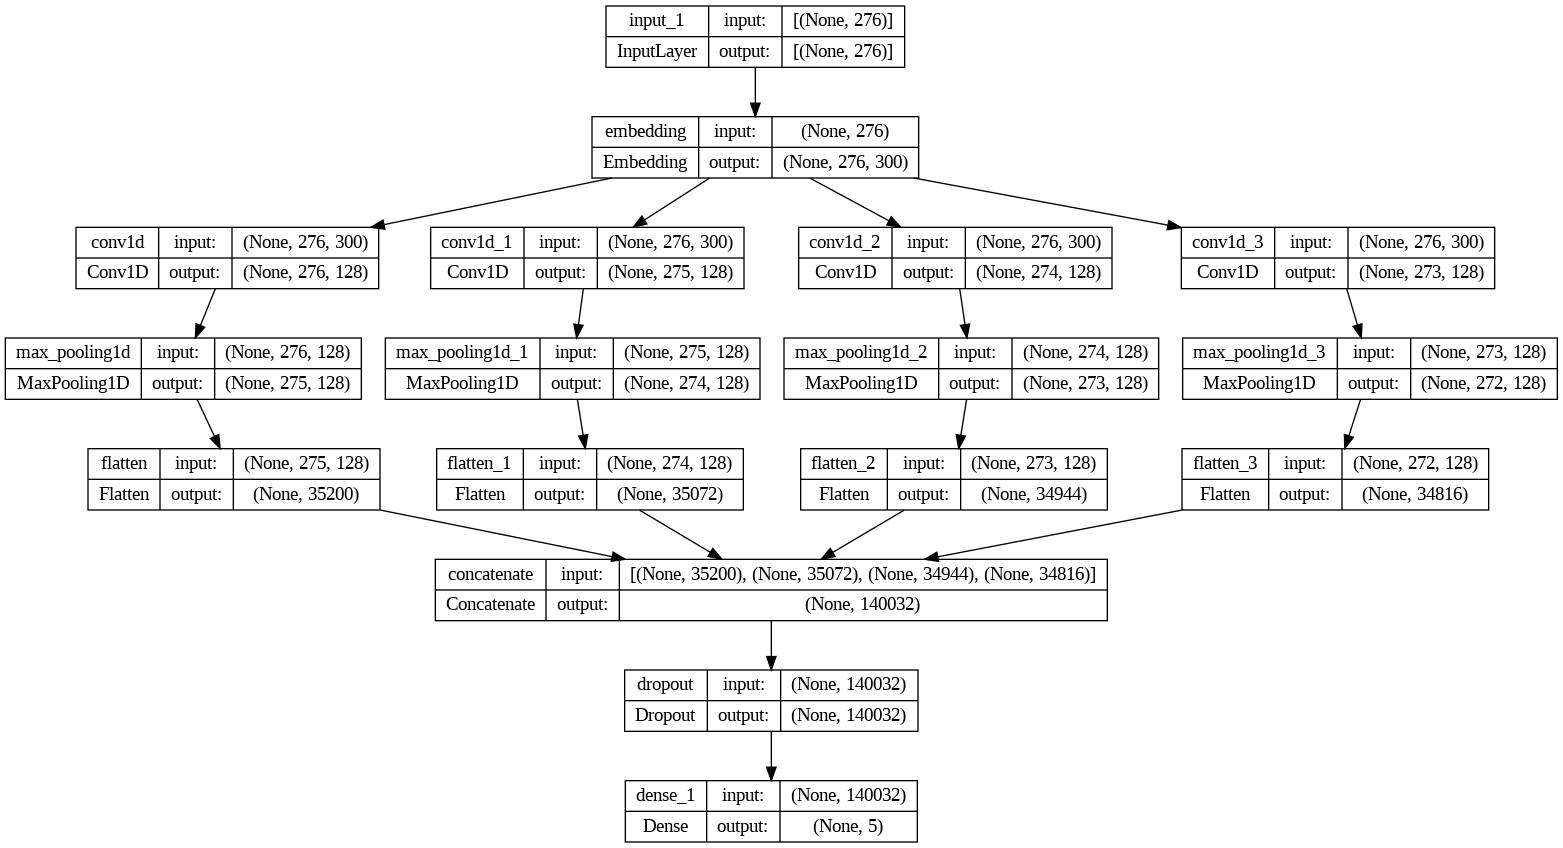

In [31]:

#print model
plot_model(model, show_shapes=True)

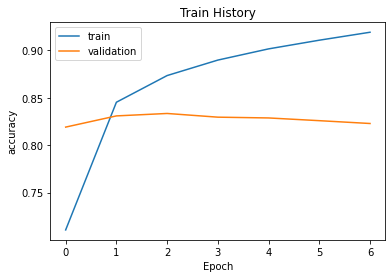

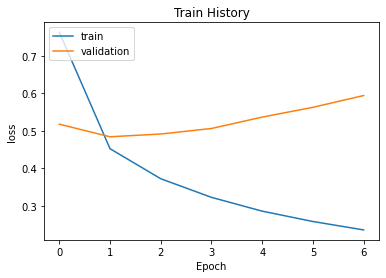

Accuracy on training data is:- 91.92070364952087 %
Loss 23.641686141490936
Accuracy on validation data is:- 82.28915333747864 %
Loss 59.43024158477783


In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

def show_train_history(train_history,train,validation):
    plt.plot(train_history.history.history[train])
    plt.plot(train_history.history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

show_train_history(model,'accuracy','val_accuracy')
show_train_history(model,'loss','val_loss') 
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
print(f"Accuracy on training data is:- {acc[-1]*100} %")
print(f"Loss {loss[-1]*100}")
print(f"Accuracy on validation data is:- {val_acc[-1]*100} %")
print(f"Loss {val_loss[-1]*100}")

In [25]:
pred6 = np.argmax(model.predict(X_test), axis =1)
slabels6=np.argmax(y_test, axis=1)
print("F1-score of LSTM CNN2Model:",f1_score(slabels6,pred6, average='macro'))
print(classification_report(slabels6,pred6))

609/609 [==============================] - 3s 4ms/step
F1-score of LSTM CNN2Model: 0.7849591121921371
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      6711
           1       0.83      0.84      0.83      5939
           2       0.74      0.74      0.74      2661
           3       0.80      0.77      0.79      2648
           4       0.71      0.65      0.68      1499

    accuracy                           0.82     19458
   macro avg       0.79      0.78      0.78     19458
weighted avg       0.82      0.82      0.82     19458

